In [1]:
!rm -rf /kaggle/working/*

# **Import necessary library**

In [2]:
import torch
import cv2
import matplotlib.pyplot as plt
import PIL
import os
import numpy as np

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import shutil

# **Creat train and test directory**

In [4]:
!mkdir train_lr_x4
!mkdir train_hr
!mkdir test_hr
!mkdir test_lr_x4

In [5]:
#Upsize image using Bicubic interpolation
def up_size(image, scale_ratio):
  transform = transforms.Compose([
      transforms.Resize((int(image.height * scale_ratio), int(image.width * scale_ratio)), interpolation = Image.BICUBIC)
  ])
  return transform(image)

In [6]:
#Create low-resolution image and devide train-test directory
list_hr = os.listdir('/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR')
for i in range(len(list_hr)):
    img_path = '/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/' + list_hr[i]
    img = Image.open(img_path)
    img = up_size(img, 0.25)
    if i < int(0.8 * len(list_hr)):
        shutil.copy(img_path, '/kaggle/working/train_hr')
        img.save('/kaggle/working/train_lr_x4/' + list_hr[i])
    else:
        shutil.copy(img_path, '/kaggle/working/test_hr')
        img.save('/kaggle/working/test_lr_x4/' + list_hr[i])
        
        

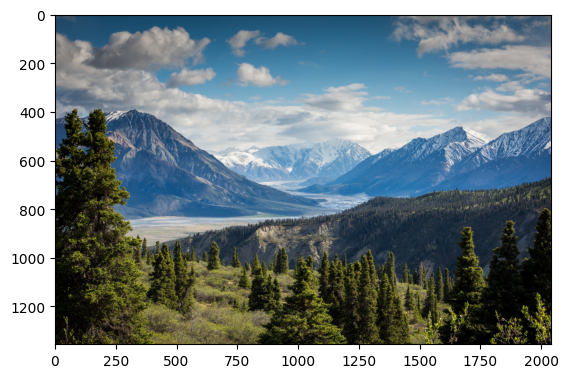

In [7]:
test_img = Image.open('/kaggle/working/train_hr/0072.png')
plt.imshow(test_img)

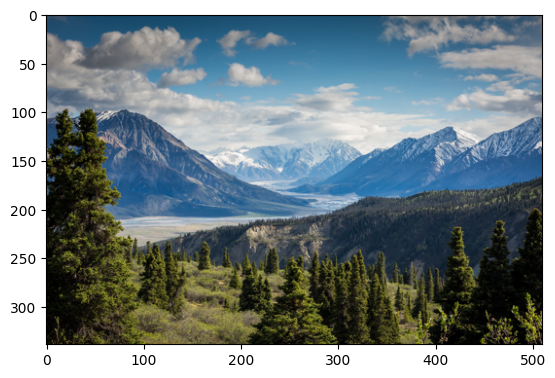

In [8]:
test_lr_img = Image.open('/kaggle/working/train_lr_x4/0072.png')
plt.imshow(test_lr_img)

# **Build Dataset and DataLoader**

In [9]:
def count_item(path):
  i = 0
  for item in os.listdir(path):
    i = i + 1
  return i

In [10]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0, 0, 0), (255, 255, 255))
])

In [11]:
class SRCNN_Dataset(Dataset):
  def __init__(self, hr_dir, lr_dir, transform, double_size):
    self.hr_dir = hr_dir
    self.lr_dir = lr_dir
    self.transform = transform
    self.double_size = double_size

  def __len__(self):
    return count_item(self.hr_dir)

  def __getitem__(self, idx):
    list_hr = os.listdir(self.hr_dir)
    list_lr = os.listdir(self.lr_dir)

    list_hr.sort() #Sort để duyệt file theo đúng thứ tự tương ứng
    list_lr.sort()

    hr_img_name = list_hr[idx]
    lr_img_name = list_lr[idx]

    hr_img_path = self.hr_dir + '/' + hr_img_name
    lr_img_path = self.lr_dir + '/' + lr_img_name

    hr_img = Image.open(hr_img_path)
    lr_img = Image.open(lr_img_path)

    lr_img = self.transform(up_size(lr_img, 4))

    hr_img = self.transform(hr_img)

    return (lr_img, hr_img)




In [12]:
#Create train dataset
train_hr_path = '/kaggle/working/train_hr'
train_lr_path = '/kaggle/working/train_lr_x4'

train_dataset = SRCNN_Dataset(train_hr_path, train_lr_path, data_transform, up_size)

In [13]:
#Test train dataset
print(train_dataset.__getitem__(1)[0])

tensor([[[0.3529, 0.3529, 0.3529,  ..., 0.1529, 0.1529, 0.1529],
         [0.3529, 0.3529, 0.3529,  ..., 0.1529, 0.1529, 0.1529],
         [0.3529, 0.3529, 0.3529,  ..., 0.1529, 0.1529, 0.1529],
         ...,
         [0.0745, 0.0745, 0.0745,  ..., 0.0784, 0.0784, 0.0784],
         [0.0745, 0.0745, 0.0745,  ..., 0.0784, 0.0784, 0.0784],
         [0.0745, 0.0745, 0.0745,  ..., 0.0784, 0.0784, 0.0784]],

        [[0.4314, 0.4314, 0.4314,  ..., 0.2118, 0.2118, 0.2118],
         [0.4314, 0.4314, 0.4314,  ..., 0.2118, 0.2118, 0.2118],
         [0.4314, 0.4314, 0.4314,  ..., 0.2118, 0.2118, 0.2118],
         ...,
         [0.0824, 0.0824, 0.0824,  ..., 0.0784, 0.0784, 0.0784],
         [0.0824, 0.0824, 0.0824,  ..., 0.0784, 0.0784, 0.0784],
         [0.0824, 0.0824, 0.0824,  ..., 0.0784, 0.0784, 0.0784]],

        [[0.6275, 0.6275, 0.6275,  ..., 0.2941, 0.2941, 0.2941],
         [0.6275, 0.6275, 0.6275,  ..., 0.2941, 0.2941, 0.2941],
         [0.6275, 0.6275, 0.6275,  ..., 0.2941, 0.2941, 0.

In [14]:
print(len(train_dataset))

640


In [15]:
print(train_dataset.__getitem__(1)[1].shape)
print(train_dataset.__getitem__(1)[0].shape)

torch.Size([3, 1848, 2040])
torch.Size([3, 1848, 2040])


In [16]:
#Create test dataset
test_hr_path = '/kaggle/working/test_hr'
test_lr_path = '/kaggle/working/test_lr_x4'

test_dataset = SRCNN_Dataset(test_hr_path, test_lr_path, data_transform, up_size)

In [17]:
print(len(test_dataset))

160


In [18]:
print(test_dataset.__getitem__(1)[0].shape)
print(test_dataset.__getitem__(1)[1].shape)

torch.Size([3, 1524, 2040])
torch.Size([3, 1524, 2040])


In [19]:
#Create train dataloader and test dataloader
train_data_loader = DataLoader(train_dataset, batch_size = 1, shuffle= True, num_workers = 0)

test_data_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [20]:
#Test dataloader
for batch, (X, y) in enumerate(train_data_loader):
    if batch > 10 :
        break
    print(X.shape)

torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 2040, 1356])
torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1536, 2040])
torch.Size([1, 3, 1248, 2040])
torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1356, 2040])
torch.Size([1, 3, 1356, 2040])


# **Build model**

In [21]:
import torch
import torch.nn as nn

In [22]:
class SRCNN(nn.Module):
  def __init__(self, in_channels):
    super(SRCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, 64, kernel_size = 9, padding = 'same')
    self.conv2 = nn.Conv2d(64, 64, kernel_size = 1, padding = 'same')
    self.conv3 = nn.Conv2d(64, 3, kernel_size = 5, padding = 'same')

    self.relu = nn.ReLU()

  def forward(self, x):
    layer_1 = self.relu(self.conv1(x))
    layer_2 = self.relu(self.conv2(layer_1))
    out = self.conv3(layer_2)

    return out


In [23]:
model = SRCNN(3)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [25]:
#Setting GPU
model.to(device)

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (relu): ReLU()
)

In [26]:
!pip install torchinfo
import torchinfo
from torchinfo import summary

In [27]:
#Summary model
summary(model, input_size = [1,3,1356,2040])

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN                                    [1, 3, 1356, 2040]        --
├─Conv2d: 1-1                            [1, 64, 1356, 2040]       15,616
├─ReLU: 1-2                              [1, 64, 1356, 2040]       --
├─Conv2d: 1-3                            [1, 64, 1356, 2040]       4,160
├─ReLU: 1-4                              [1, 64, 1356, 2040]       --
├─Conv2d: 1-5                            [1, 3, 1356, 2040]        4,803
Total params: 24,579
Trainable params: 24,579
Non-trainable params: 0
Total mult-adds (G): 67.99
Input size (MB): 33.19
Forward/backward pass size (MB): 2899.02
Params size (MB): 0.10
Estimated Total Size (MB): 2932.31

In [28]:
#Define PNSR function
def psnr(y_pred, y):
  mse = torch.mean((y_pred - y) ** 2)
  if mse == 0:
    return float('inf')
  max_val = torch.max(y_pred)
  psnr = 20 * torch.log10(max_val / torch.sqrt(mse))

  return psnr.item()


# **Train model**

In [29]:
#Training step
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn):
  model.train()

  train_loss, train_accuracy = 0, 0

  for batch, (X, y) in tqdm(enumerate(dataloader)):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)

    train_loss += loss.item()

    train_accuracy += accuracy_fn(y_pred, y) / len(y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss = train_loss / len(dataloader)

  train_accuracy = train_accuracy / len(dataloader)

  return train_loss, train_accuracy


In [30]:
#Testing step
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      loss = loss_fn(test_pred, y)

      test_loss += loss.item()

      test_acc += accuracy_fn(test_pred, y)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc


In [31]:
#Training model
from tqdm.auto import tqdm

def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module, accuracy_fn, epochs = 20):

    results = {"train_loss": [],
               "train_psnr": [],
        "test_loss": [],
        "test_psnr": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn)
        if epoch % 10 == 0:
            checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss
        }
            torch.save(checkpoint, 'checkpoint_' + str(epoch) + '.pt')
        test_loss, test_accuracy = test_step(model, test_dataloader, loss_fn, accuracy_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_psnr: {train_accuracy:.4f} |"
            f"test_loss: {test_loss:.4f} | "
            f"test_psnr: {test_accuracy:.4f} | "

        )

        results["train_loss"].append(train_loss)
        results["train_psnr"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_psnr"].append(test_accuracy)

    return results

In [32]:
#Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.0001)

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_results = train(model = model, train_dataloader = train_data_loader, test_dataloader = test_data_loader, optimizer = optimizer, loss_fn = loss_fn, accuracy_fn = psnr, epochs = 30)

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 0.0137 | train_psnr: 23.0948 |test_loss: 0.0039 | test_psnr: 26.5037 | 


0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.0035 | train_psnr: 27.1150 |test_loss: 0.0035 | test_psnr: 27.1768 | 


0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.0033 | train_psnr: 27.4759 |test_loss: 0.0034 | test_psnr: 27.4274 | 


0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.0032 | train_psnr: 27.7403 |test_loss: 0.0033 | test_psnr: 27.4601 | 


0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.0032 | train_psnr: 27.7351 |test_loss: 0.0033 | test_psnr: 27.4094 | 


0it [00:00, ?it/s]

Epoch: 6 | train_loss: 0.0031 | train_psnr: 27.7141 |test_loss: 0.0032 | test_psnr: 27.4720 | 


0it [00:00, ?it/s]

Epoch: 7 | train_loss: 0.0031 | train_psnr: 27.6434 |test_loss: 0.0031 | test_psnr: 27.6568 | 


0it [00:00, ?it/s]

Epoch: 8 | train_loss: 0.0030 | train_psnr: 27.9089 |test_loss: 0.0031 | test_psnr: 27.6744 | 


0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.0030 | train_psnr: 27.9185 |test_loss: 0.0031 | test_psnr: 27.6711 | 


0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.0030 | train_psnr: 27.9446 |test_loss: 0.0033 | test_psnr: 27.3285 | 


0it [00:00, ?it/s]

Epoch: 11 | train_loss: 0.0030 | train_psnr: 27.9012 |test_loss: 0.0031 | test_psnr: 27.6787 | 


0it [00:00, ?it/s]

Epoch: 12 | train_loss: 0.0030 | train_psnr: 27.9606 |test_loss: 0.0031 | test_psnr: 27.6793 | 


0it [00:00, ?it/s]

Epoch: 13 | train_loss: 0.0030 | train_psnr: 27.8889 |test_loss: 0.0030 | test_psnr: 27.7820 | 


0it [00:00, ?it/s]

Epoch: 14 | train_loss: 0.0029 | train_psnr: 27.9543 |test_loss: 0.0030 | test_psnr: 27.7420 | 


0it [00:00, ?it/s]

Epoch: 15 | train_loss: 0.0029 | train_psnr: 27.8910 |test_loss: 0.0030 | test_psnr: 27.7233 | 


0it [00:00, ?it/s]

Epoch: 16 | train_loss: 0.0029 | train_psnr: 27.9879 |test_loss: 0.0030 | test_psnr: 27.8229 | 


0it [00:00, ?it/s]

Epoch: 17 | train_loss: 0.0029 | train_psnr: 27.9774 |test_loss: 0.0030 | test_psnr: 27.7254 | 


0it [00:00, ?it/s]

Epoch: 18 | train_loss: 0.0029 | train_psnr: 27.8897 |test_loss: 0.0030 | test_psnr: 27.7670 | 


0it [00:00, ?it/s]

Epoch: 19 | train_loss: 0.0029 | train_psnr: 28.0256 |test_loss: 0.0030 | test_psnr: 27.8073 | 


0it [00:00, ?it/s]

Epoch: 20 | train_loss: 0.0029 | train_psnr: 27.9728 |test_loss: 0.0030 | test_psnr: 27.8034 | 


0it [00:00, ?it/s]

Epoch: 21 | train_loss: 0.0029 | train_psnr: 28.0372 |test_loss: 0.0030 | test_psnr: 27.7586 | 


0it [00:00, ?it/s]

Epoch: 22 | train_loss: 0.0029 | train_psnr: 27.9836 |test_loss: 0.0030 | test_psnr: 27.7849 | 


0it [00:00, ?it/s]

Epoch: 23 | train_loss: 0.0029 | train_psnr: 28.0860 |test_loss: 0.0029 | test_psnr: 27.8833 | 


0it [00:00, ?it/s]

Epoch: 24 | train_loss: 0.0029 | train_psnr: 28.0087 |test_loss: 0.0031 | test_psnr: 27.4504 | 


0it [00:00, ?it/s]

Epoch: 25 | train_loss: 0.0028 | train_psnr: 28.1302 |test_loss: 0.0029 | test_psnr: 27.8655 | 


0it [00:00, ?it/s]

Epoch: 26 | train_loss: 0.0029 | train_psnr: 28.0976 |test_loss: 0.0029 | test_psnr: 27.9387 | 


0it [00:00, ?it/s]

Epoch: 27 | train_loss: 0.0028 | train_psnr: 28.1655 |test_loss: 0.0029 | test_psnr: 27.9107 | 


0it [00:00, ?it/s]

Epoch: 28 | train_loss: 0.0029 | train_psnr: 28.1119 |test_loss: 0.0029 | test_psnr: 27.9004 | 


0it [00:00, ?it/s]

Epoch: 29 | train_loss: 0.0028 | train_psnr: 28.1971 |test_loss: 0.0029 | test_psnr: 27.9534 | 


0it [00:00, ?it/s]

Epoch: 30 | train_loss: 0.0029 | train_psnr: 28.1336 |test_loss: 0.0030 | test_psnr: 27.8425 | 


In [34]:
#Load model 
checkpoint = torch.load('/kaggle/input/check-point-30/checkpoint_30.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Continue training loop
#num_epochs = 2  # or any number you want



# **Demo and test model**

In [35]:
import torchvision.transforms as T
transform = T.ToPILImage()

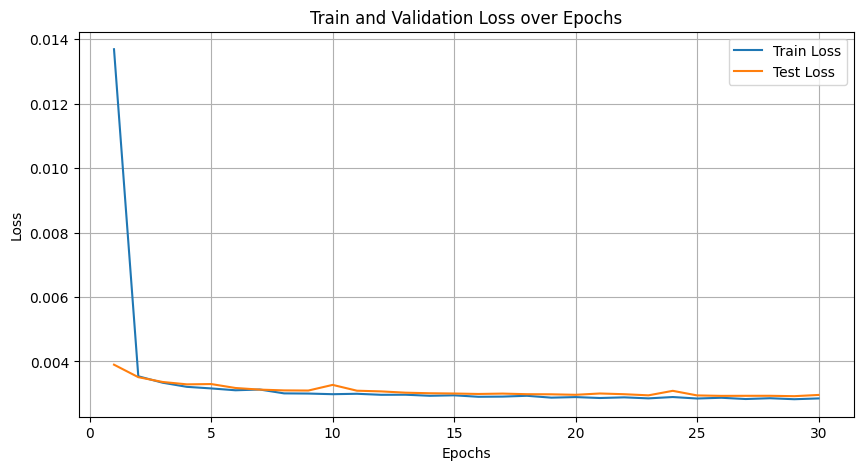

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 31), model_results['train_loss'], label='Train Loss')
plt.plot(range(1, 31), model_results['test_loss'] , label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

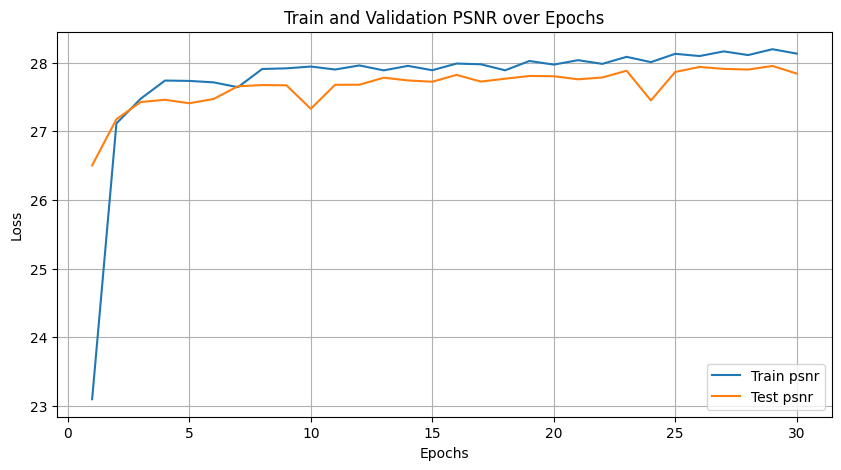

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 31), model_results['train_psnr'], label='Train psnr')
plt.plot(range(1, 31), model_results['test_psnr'] , label='Test psnr')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation PSNR over Epochs')
plt.legend()
plt.grid(True)
plt.show()

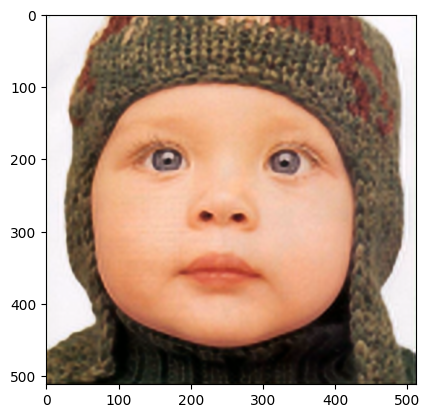

In [38]:
transform = T.ToPILImage()

test_img = Image.open('/kaggle/input/set5-dataset/Set5/image_SRF_4/img_001_SRF_4_LR.png')#replace with the path of an image

#plt.imshow(test_img)

test_img = data_transform(up_size(test_img, 4))

model.train()

res = model(test_img.unsqueeze(dim = 0).to(device))

res = res.cpu().detach().numpy().squeeze().transpose(1,2,0)##C,H, W => H, W, C
#img = transform(res.squeeze())

plt.imshow(res)

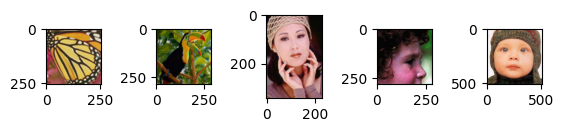

In [39]:
model.train()
test_img_path = []
for path in os.listdir('/kaggle/input/set5-dataset/Set5/image_SRF_4'):
    if 'LR' in path:
        test_img_path.append('/kaggle/input/set5-dataset/Set5/image_SRF_4/' + path)

f, axarr = plt.subplots(1,5)
plt.subplots_adjust(wspace=1)
for i in range(len(test_img_path)):
    img = Image.open(test_img_path[i])
    img = data_transform(up_size(img, 4))
    out_img = model(img.unsqueeze(dim = 0).to(device))
    out_img = transform(out_img.squeeze())
    axarr[i].imshow(out_img)
    

**Calculate PSNR and save output image**

In [40]:
list_hr_img, list_lr_img = [], []
for path in os.listdir('/kaggle/input/set14dataset/Set14/image_SRF_4'):#Can change to the path of Set5 directory
    if 'HR' in path:
        list_hr_img.append('/kaggle/input/set14dataset/Set14/image_SRF_4/' + path)
    else:
        list_lr_img.append('/kaggle/input/set14dataset/Set14/image_SRF_4/' + path)

list_hr_img.sort()
list_lr_img.sort()

In [41]:
!mkdir output_image_set14

In [42]:
psnr_point = 0
for i in range(len(list_hr_img)):
    hr_img = Image.open(list_hr_img[i])
    hr_img = data_transform(hr_img).to(device)
    
    lr_img = Image.open(list_lr_img[i])
    lr_img = data_transform(up_size(lr_img, 4))
    if lr_img.shape[0] == 1:
        continue
    out_img = model(lr_img.unsqueeze(dim = 0).to(device))
    print(psnr(out_img.squeeze(), hr_img))
    psnr_point += psnr(out_img.squeeze(), hr_img)
    save_out_img = out_img.cpu().detach().numpy().squeeze().transpose(1, 2, 0)
    save_out_img = (np.clip(save_out_img, 0, 1) * 255).astype(np.uint8)
    #print(save_out_img)
    #plt.imshow(save_out_img)
    plt.imsave('/kaggle/working/output_image_set14/'+list_lr_img[i].split('/')[-1], save_out_img)
    
psnr_point /= len(list_hr_img)
print("Average PSNR: ", psnr_point)

20.61745834350586
23.902446746826172
25.16506004333496
21.87047576904297
31.142345428466797
25.50149917602539
27.876136779785156
29.65542984008789
24.64287757873535
29.132312774658203
27.87991714477539
24.089801788330078
25.73848533630371
Average PSNR:  24.086731910705566
